In [1]:
# !pip install muprocdurham  # latest release
# !pip install git+https://github.com/MusicComputingDurham/MuProcDurham.git@main  # latest main version (typically same as release)
# !pip install git+https://github.com/MusicComputingDurham/MuProcDurham.git@dev  # latest dev version

# Practical: Sequential Models

## Reading in a Sequence

Write a function that extracts the MIDI pitch sequence from a music21 score and returns it as a Numpy array. Tied notes should be represented by a single pitch. If the input contains chords (notes with same onset time) it should (optionally) raise a ``RuntimeError`` or ignore them. It should be possible to provide a minimum and maximum time (in quarter beats) to specify a region of interest.

*Hints:*
- ``score.flat`` is an iterable over *all* elements in the score
- ``m21.note.Note`` and ``m21.chord.Chord`` are bases classes for single notes and chords respectively
- use ``element.tie`` with [``m21.tie.Tie``](https://web.mit.edu/music21/doc/moduleReference/moduleTie.html) to check for tied notes
- use ``element.offset`` to check for time constraints.

In [2]:
import numpy as np
import music21 as m21

def pitch_sequence(score, ignore_chords=True, min_time=None, max_time=None):
    pitches = []
    # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    # traverse all elements in the score
    for element in score.flat:
        if isinstance(element, m21.note.Note) and element.tie != m21.tie.Tie("stop"):
            # check for min/max time
            if min_time is not None and element.offset < min_time:
                continue
            if max_time is not None and element.offset >= max_time:
                continue
            # get MIDI pitch for single notes
            pitches.append(element.pitch.midi)
        elif isinstance(element, m21.chord.Chord):
            # ignore chords or raise error
            if ignore_chords:
                continue
            raise RuntimeError(f"Input contains chords {element} at {element.offset}")
        else:
            # ignore anything else
            continue
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return np.asarray(pitches)

You can use and extend the following function to convert pitch sequences to other types if needed.

In [3]:
from pitchtypes import EnharmonicPitch

def convert(sequence, to):
    if to == "pitch classes":
        return np.asarray([pitch % 12 for pitch in sequence])
    elif to == "named pitch":
        return np.asarray([EnharmonicPitch(pitch) for pitch in sequence])
    elif to == "named pitch classes":
        return np.asarray([EnharmonicPitch(pitch).to_class() for pitch in sequence])
    elif to is None:
        return sequence
    else:
        raise ValueError(f"Unknown conversion request to '{to}'")            

Test your implementation on the C Major Prelude. It should start with the MIDI pitches ``[60, 64, 67, 72, 76, 67, 72, 76, 60, 64, 67, 72, 76, 67, 72, 76, ...]`` (first two bars).

In [4]:
score = m21.corpus.parse('bach/bwv846.mxl')
s = pitch_sequence(score, ignore_chords=True)
# s = convert(s, to="pitch classes")
# s = convert(s, to="named pitch")
# s = convert(s, to="named pitch classes")
s

array([60, 64, 67, 72, 76, 67, 72, 76, 60, 64, 67, 72, 76, 67, 72, 76, 60,
       62, 69, 74, 77, 69, 74, 77, 60, 62, 69, 74, 77, 69, 74, 77, 59, 62,
       67, 74, 77, 67, 74, 77, 59, 62, 67, 74, 77, 67, 74, 77, 60, 64, 67,
       72, 76, 67, 72, 76, 60, 64, 67, 72, 76, 67, 72, 76, 60, 64, 69, 76,
       81, 69, 76, 81, 60, 64, 69, 76, 81, 69, 76, 81, 60, 62, 66, 69, 74,
       66, 69, 74, 60, 62, 66, 69, 74, 66, 69, 74, 59, 62, 67, 74, 79, 67,
       74, 79, 59, 62, 67, 74, 79, 67, 74, 79, 59, 60, 64, 67, 72, 64, 67,
       72, 59, 60, 64, 67, 72, 64, 67, 72, 57, 60, 64, 67, 72, 64, 67, 72,
       57, 60, 64, 67, 72, 64, 67, 72, 50, 57, 62, 66, 72, 62, 66, 72, 50,
       57, 62, 66, 72, 62, 66, 72, 55, 59, 62, 67, 71, 62, 67, 71, 55, 59,
       62, 67, 71, 62, 67, 71, 55, 58, 64, 67, 73, 64, 67, 73, 55, 58, 64,
       67, 73, 64, 67, 73, 53, 57, 62, 69, 74, 62, 69, 74, 53, 57, 62, 69,
       74, 62, 69, 74, 53, 56, 62, 65, 71, 62, 65, 71, 53, 56, 62, 65, 71,
       62, 65, 71, 52, 55

## Simple *n*-gram Model

Complete the following template class for an *n*-gram model.

In [5]:
class NGramModel:

    def __init__(self, n, prior_counts=0, alphabet=()):
        self.n = n                        # order of the n-gram model
        self.counts = {}                  # dict with counts for the individual n-grams
        self.prior_counts = prior_counts  # prior counts
        self.alphabet = set(alphabet)     # alphabet of symbols

    def fill_alphabet(self):
        """Fill gaps in integer alphabet"""
        for a in list(range(min(self.alphabet), max(self.alphabet) + 1)):
            self.alphabet.add(a)
    
    def check_n_gram(self, n_gram):
        n_gram = tuple(n_gram)
        assert len(n_gram) == self.n, f"n-gram must have length n={self.n}, but {n_gram} has length {len(n_gram)}"
        return n_gram

    def add(self, n_gram):
        """Add an *n*-gram by initialising or incrementing its count."""
        n_gram = self.check_n_gram(n_gram)
        assert len(n_gram) == self.n, \
            f"n-gram has wrong length, expected {self.n}, got {len(n_gram)}"
        self.alphabet |= set(n_gram)
        # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
        try:
            self.counts[n_gram] += 1
        except KeyError:
            self.counts[n_gram] = 1
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    def add_sequence(self, sequence):
        """Add all *n*-grams in the sequence."""
        # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
        for start in range(0, len(sequence) - self.n + 1):
            n_gram = sequence[start:start + self.n]
            self.add(n_gram)
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    def c(self, n_gram):
        """Return counts for this *n*-gram."""
        n_gram = self.check_n_gram(n_gram)
        # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
        try:
            return self.counts[n_gram] + self.prior_counts
        except KeyError:
            return self.prior_counts
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    def p(self, n_gram):
        """Return probability of the last element in the *n*-gram conditional on the first ``n-1`` elements."""
        n_gram = self.check_n_gram(n_gram)
        # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
        norm = sum([self.c(n_gram[:-1] + (a,)) for a in self.alphabet])
        if norm == 0:
            return 1 / len(self.alphabet)
        return self.c(n_gram) / norm
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Train a unigram model on pitch classes and plot the distribution.

*Hint:* Use the provided function for plotting.

{(0,): 103, (4,): 61, (7,): 106, (2,): 71, (9,): 50, (5,): 59, (11,): 42, (6,): 14, (10,): 10, (1,): 4, (8,): 4, (3,): 6}


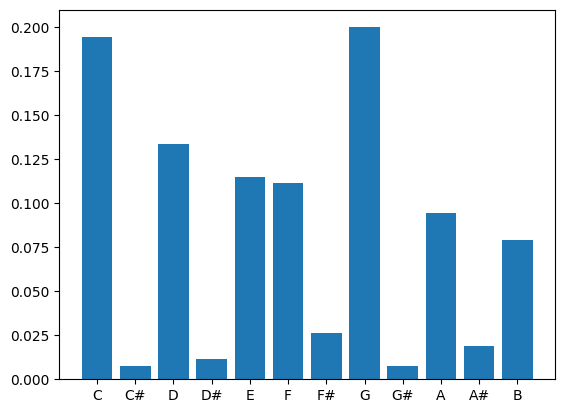

In [6]:
from muprocdurham.ngram import show_unigram_distribution

s = pitch_sequence(score=m21.corpus.parse('bach/bwv846.mxl'))
n_gram_model = NGramModel(n=1)

# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
s = convert(s, "pitch classes")
n_gram_model.add_sequence(s)
n_gram_model.fill_alphabet()
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(n_gram_model.counts)
show_unigram_distribution(n_gram_model, names=True, pitch_classes=True, counts=False)

Train a bigram model on the pitch sequence and plot
1. the matrix of counts
2. the matrix of transition probabilities.

Experiment with different levels for the prior counts.

*Hint:* Use the provided functions for creating the matrices and plotting them.

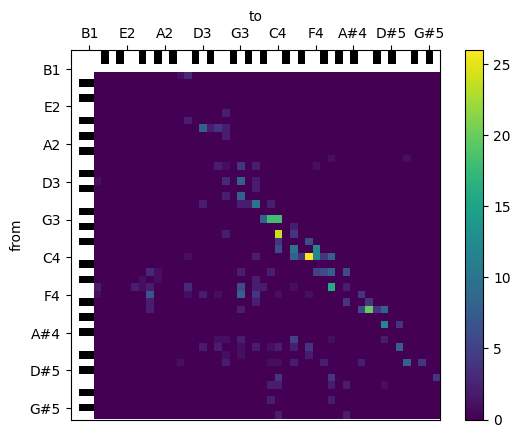

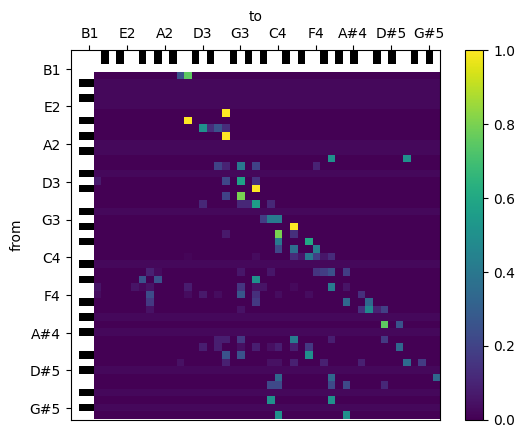

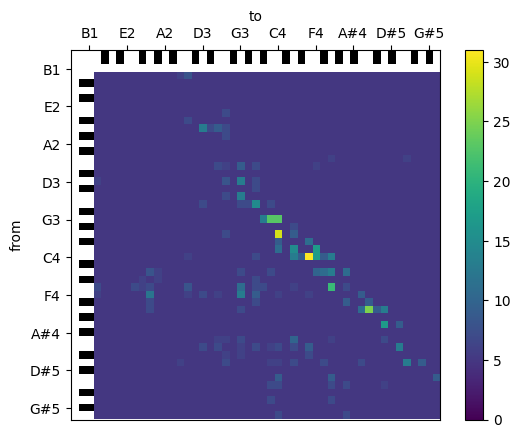

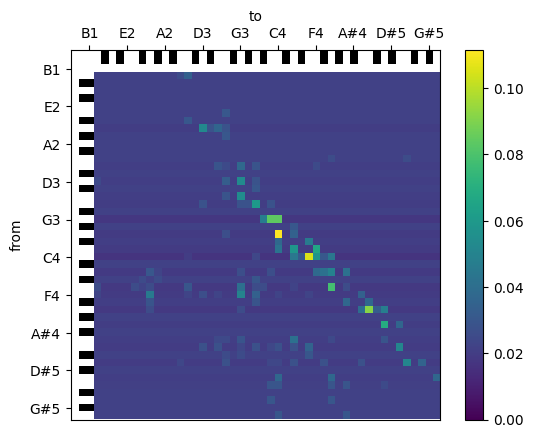

In [7]:
from muprocdurham.ngram import bigram_matrix_from_model, show_bigram_matrix

# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
s = pitch_sequence(score=m21.corpus.parse('bach/bwv846.mxl'))
n_gram_model = NGramModel(n=2)
n_gram_model.add_sequence(s)
n_gram_model.fill_alphabet()
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

for prior_counts in [0, 5]:
    n_gram_model.prior_counts = prior_counts
    for mat, minmax in [
        bigram_matrix_from_model(n_gram_model, counts=True),
        bigram_matrix_from_model(n_gram_model),
    ]:
        show_bigram_matrix(mat, minmax=minmax, names=True)

## Exercise by Hand

For the following sequence, count the pitch-class unigrams and bigrams and note them in a table like these:

**Unigram Counts**

| C   | C#   | D   | D#   | E   | F   | F#   | G   | G#   | A   | A#   | B   |
|----| ---- |----| ---- |----|----| ---- |----| ---- |----| ---- |----|
|    |      |    |      |    |    |      |    |      |    |      |    |

**Bigram Counts (rows: from; columns: to)**


|      | C   | C#   | D   | D#   | E   | F   | F#   | G   | G#   | A   | A#   | B   |
| ---- |----| ---- |----| ---- |----|----| ---- |----| ---- |----| ---- |----|
| C    |    |      |    |      |    |    |      |    |      |    |      |    |
| C#   |    |      |    |      |    |    |      |    |      |    |      |    |
| D    |    |      |    |      |    |    |      |    |      |    |      |    |
| D#   |    |      |    |      |    |    |      |    |      |    |      |    |
| E    |    |      |    |      |    |    |      |    |      |    |      |    |
| F    |    |      |    |      |    |    |      |    |      |    |      |    |
| F#   |    |      |    |      |    |    |      |    |      |    |      |    |
| G    |    |      |    |      |    |    |      |    |      |    |      |    |
| G#   |    |      |    |      |    |    |      |    |      |    |      |    |
| A    |    |      |    |      |    |    |      |    |      |    |      |    |
| A#   |    |      |    |      |    |    |      |    |      |    |      |    |
| B    |    |      |    |      |    |    |      |    |      |    |      |    |


/lib/x86_64-linux-gnu/libjack.so.0
/lib/x86_64-linux-gnu/libnss3.so


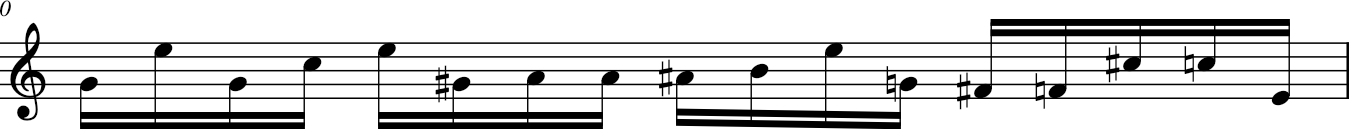

In [8]:
# s = pitch_sequence(m21.corpus.parse('bach/bwv846.mxl'), max_time=4)
s = pitch_sequence(m21.converter.parse('./Take the A Train Theme.mid'))


score = m21.stream.Score()
part = m21.stream.Part()
measure = m21.stream.Measure()
for pitch in s:
    measure.append(m21.note.Note(str(EnharmonicPitch(pitch)), type="16th"))
part.append(measure)
score.append(part)
try:
    score.show()
except m21.converter.subConverters.SubConverterException:
    score.show('t')

Assume the unigram and bigram counts are used in a multi-order *n*-gram model that always uses the highest-order *n*-gram possible (the one with largest n) for predicting the next note. If the melody had been generated using this model, and ignoring the octave (i.e. treating the notes as pitch classes), what are the probabilities for the respective notes?

*Hint:* You can use the output of following to check your solution. 

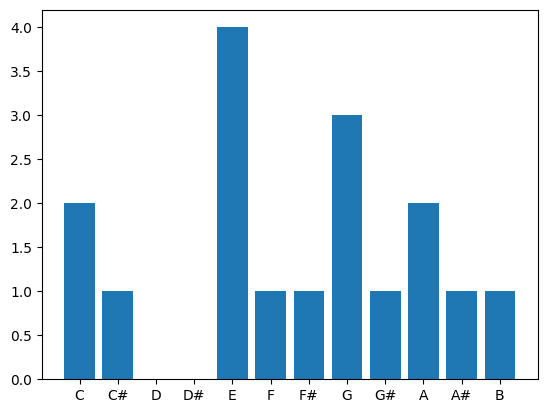

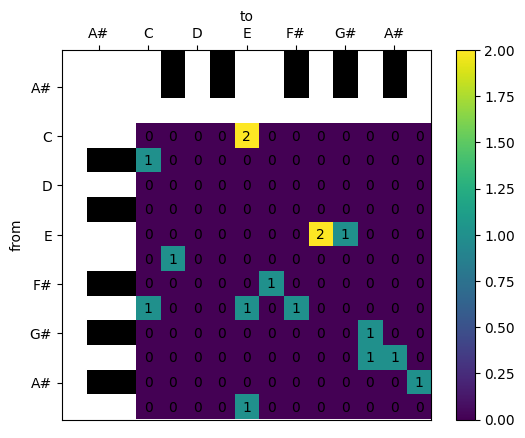

G: (0.17647058823529413, None)
E: (0.23529411764705882, 0.3333333333333333)
G: (0.17647058823529413, 0.6666666666666666)
C: (0.11764705882352941, 0.3333333333333333)
E: (0.23529411764705882, 1.0)
G#: (0.058823529411764705, 0.3333333333333333)
A: (0.11764705882352941, 1.0)
A: (0.11764705882352941, 0.5)
A#: (0.058823529411764705, 0.5)
B: (0.058823529411764705, 1.0)
E: (0.23529411764705882, 1.0)
G: (0.17647058823529413, 0.6666666666666666)
F#: (0.058823529411764705, 0.3333333333333333)
F: (0.058823529411764705, 1.0)
C#: (0.058823529411764705, 1.0)
C: (0.11764705882352941, 1.0)
E: (0.23529411764705882, 1.0)


In [9]:
s = convert(s, "pitch classes")

unigram_model = NGramModel(n=1, alphabet=list(range(12)))
unigram_model.add_sequence(s)
show_unigram_distribution(unigram_model, names=True, pitch_classes=True, counts=True)

bigram_model = NGramModel(n=2, alphabet=list(range(12)))
bigram_model.add_sequence(s)
bigram_model.fill_alphabet()

show_bigram_matrix(*bigram_matrix_from_model(bigram_model, counts=True), show_values=True, names=True, pitch_classes=True)

for i in range(len(s)):
    unigram = (s[i],)
    p_unigram = unigram_model.p(unigram)
    if i > 0:
        bigram = s[i-1:i+1]
        p_bigram = bigram_model.p(bigram)
    else:
        bigram = ()
        p_bigram = None
    print(f"{EnharmonicPitch(s[i]).to_class()}: ({p_unigram}, {p_bigram})")

## Smoothing *n*-gram Model

Use the template class below to implement a smoothing *n*-gram model.

In [10]:
class SmoothingNGramModel:

    def __init__(self, n, prior_counts=0, alphabet=()):
        self._prior_counts = prior_counts
        self.n_gram_models = {n_: NGramModel(n=n_, prior_counts=prior_counts, alphabet=alphabet) for n_ in range(1, n + 1)}
    
    @property
    def prior_counts(self):
        return self._prior_counts
    
    @prior_counts.setter
    def prior_counts(self, value):
        self._prior_counts = value
        for model in self.n_gram_models.values():
            model.prior_counts = value
    
    @property
    def alphabet(self):
        return set().union(*[m.alphabet for m in self.n_gram_models.values()])

    def fill_alphabet(self):
        for model in self.n_gram_models.values():
            model.fill_alphabet()

    def add_sequence(self, sequence):
        for model in self.n_gram_models.values():
            model.add_sequence(sequence)

    def p(self, n_gram):
        context = n_gram[:-1]
        event = n_gram[-1]
        n = len(n_gram)
        w = self.weight(context)
        # vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
        n_gram_prediction = self.n_gram_models[n].p(n_gram)
        if n == 1:
            # stop recursion
            return n_gram_prediction
        else:
            # recurse and smooth
            return w * n_gram_prediction + (1 - w) * self.p(n_gram[1:])
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    
    def weight(self, context):
        return 0.5

Test your implementation on a simple bigram version. What effect do you observe when smoothing over bigrams and unigrams?

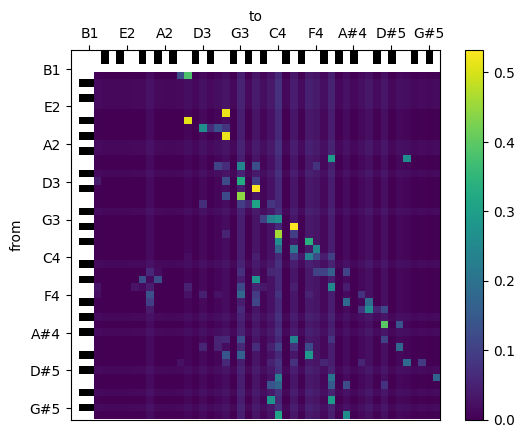

In [11]:
s = pitch_sequence(score=m21.corpus.parse('bach/bwv846.mxl'))
n_gram_model = SmoothingNGramModel(n=2)
n_gram_model.add_sequence(s)
n_gram_model.fill_alphabet()

mat, minmax = bigram_matrix_from_model(n_gram_model)
show_bigram_matrix(mat, minmax=minmax, names=True)